In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import get_ts

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
df = get_ts(days=600)

In [4]:
df.head()

,prices
dates,
2020-03-01,0.139774
2020-03-02,0.142004
2020-03-03,0.165838
2020-03-04,0.154394
2020-03-05,0.163471


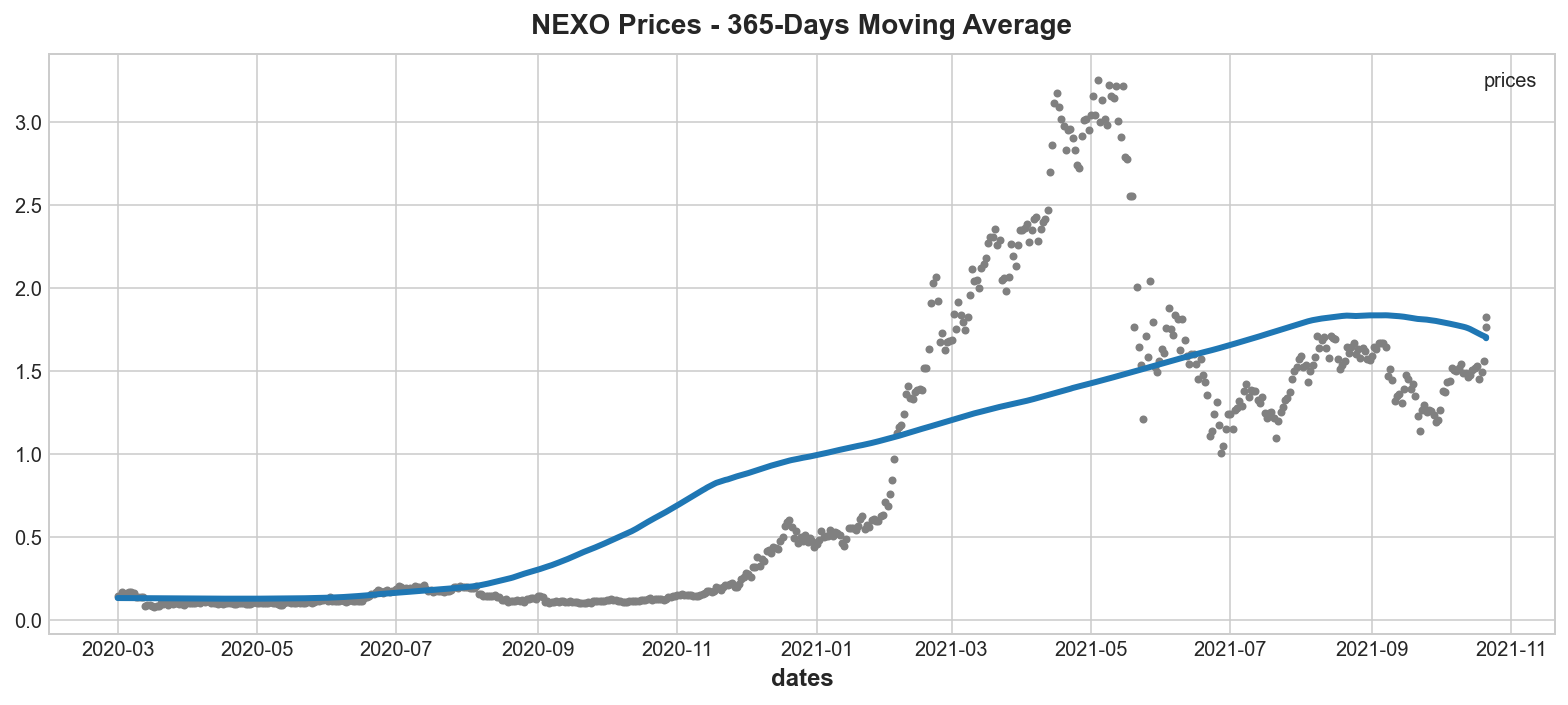

In [10]:
window = 365
min_periods = window // 2

moving_average = df.rolling(
    window=window,       # x-days window
    center=True,      # puts the average at the center of the window
    min_periods=min_periods,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title=f"NEXO Prices - {window}-Days Moving Average", legend=False,
);

In [55]:
# https://www.kaggle.com/learn/time-series
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
dates,,
2020-03-01,1.0,1.0
2020-03-02,1.0,2.0
2020-03-03,1.0,3.0
2020-03-04,1.0,4.0
2020-03-05,1.0,5.0


In [7]:
from sklearn.linear_model import LinearRegression

y = df["prices"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

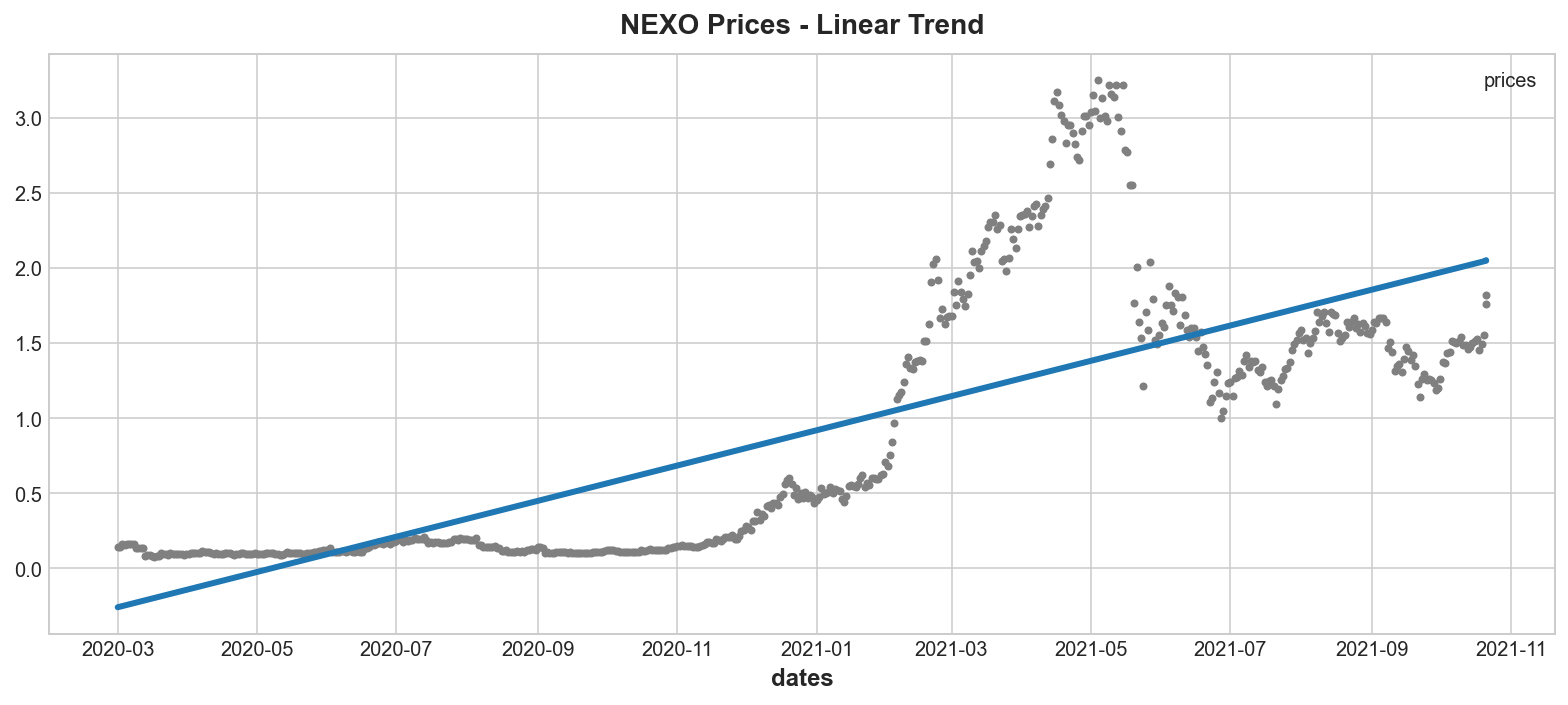

In [8]:
ax = df.plot(style=".", color="0.5", title="NEXO Prices - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

Even though the linear model looks quite different with the 365 days moving average and is obviously a bad fit, for simplicity and interpretability we'll continue working with it for now.

In [70]:
forecast_n_days = 30
forecast_index = pd.date_range(df.index.max(), periods=forecast_n_days+1).tolist()[1:]

X = dp.out_of_sample(steps=forecast_n_days,forecast_index=forecast_index)
y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2021-10-22    2.058483
2021-10-23    2.062339
2021-10-24    2.066194
2021-10-25    2.070049
2021-10-26    2.073904
dtype: float64

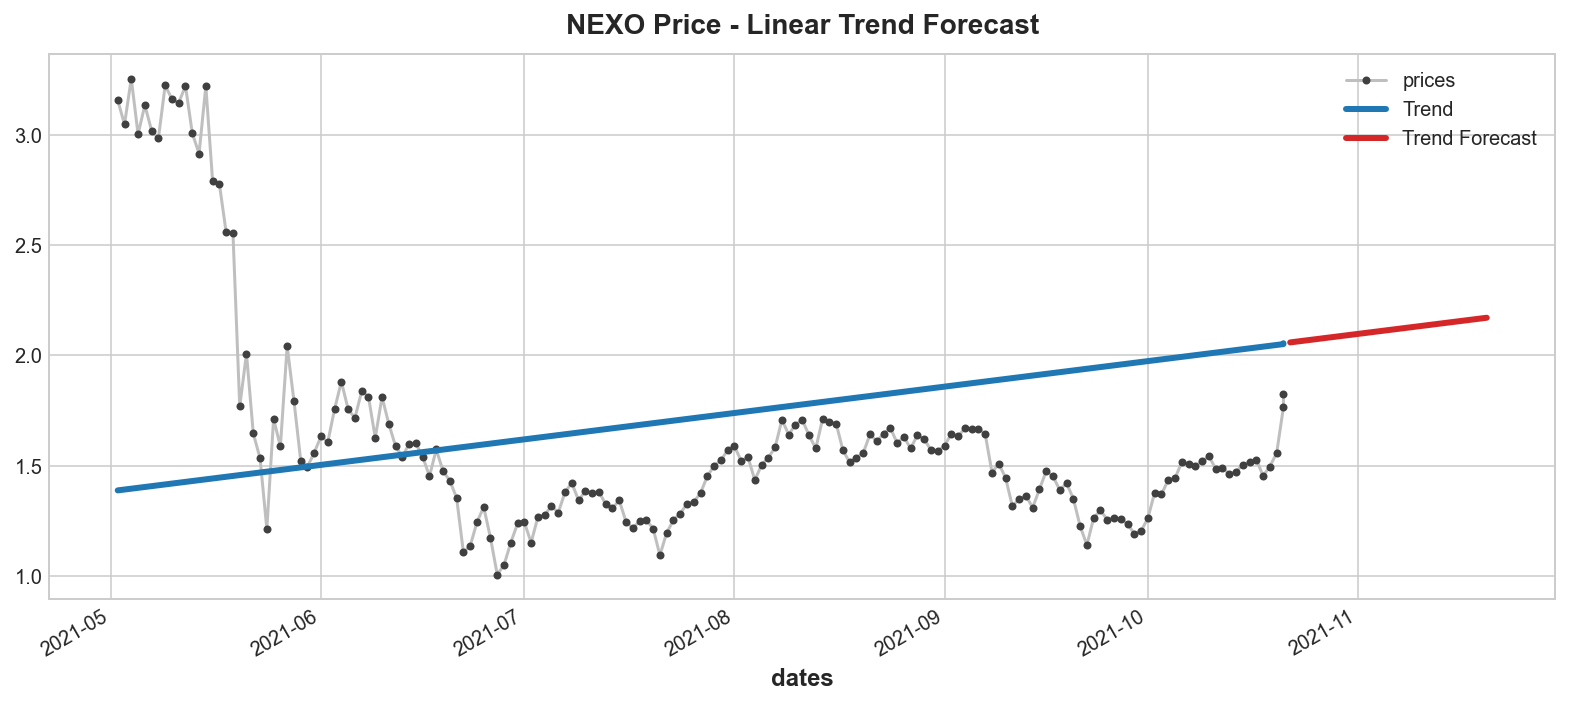

In [69]:
from datetime import datetime

min_date = datetime.strptime("2021-05", '%Y-%m').date()

ax = df[df.index > min_date].plot(title="NEXO Price - Linear Trend Forecast", **plot_params)
ax = y_pred[y_pred.index > min_date].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()